In [1]:
%matplotlib inline

from functools import partial
from pathlib import Path

import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from plothelper import *

Matplotlib Version: 3.7.1


In [2]:
def s(s0: float, x: float, R: float, i: int = 1) -> float:
    """Compute s(x+R) which gives the area per chain at distance X from the grafting surface.

    $s(x+r) = s(R)(1+ x/R)^(i-1)$

    Args:
        s0 (float): area per chair at the grafting surface
        x (float): Distance from grafting surface
        R (float): Radius of the geometry
        i (int, optional): Geometry index in {1,2,3} where 1 is planar, 2 is cylindrical, and 3 is spherical. Defaults to 1, planar.

    Returns:
        float: Area per chain at distance x from grafting surface
    """
    if i == 1:
        return s0
    else:
        return s0 * np.pow(1 + x / R, i)


def milliMolarToNumberDensity(c: float) -> float:
    """Convert mM to #nm^-3

    Args:
        c (float): Input concentration

    Returns:
        float: Output number density in #nm^-3 units
    """
    return c * 6.022e-4


In [3]:
def computeForce(
    cp: float,
    phi: float,
    # s0: float,
    i: int,
    a: float,
    alpha: float,
    A: float,
    B: float,
    d: float,
    N: int,
    verbose: bool = False,
) -> float:
    """_summary_

    Args:
        cp (float): Protein concentration in mM
        phi (float): Ionic concentration in mM
        s0 (float): Baseline area per chain nm^2
        i (int): Geometry index 1=plane; 2=cylinder; 3=sphere
        a (float): Monomer/Kuhn length in nm
        alpha (float): Degree of ionization
        A (float): Second virial coefficient
        B (float): Third virial coefficient
        N (float): Number of units

    Returns:
        float: _description_
    """
    if N * a < d:
        raise RuntimeError(f"Protein thickness (d={d}) is greater than stretched polymer (Na={N*a})")

    cp = milliMolarToNumberDensity(cp)
    phi = milliMolarToNumberDensity(phi)

    if cp == 0:
        F_elastic = 0
        F_virial = 0
        F_ion = 0
    
    else:
        s0 = N / (d * cp)

        if verbose:
            print(f"N = {N}, len = {N*a} nm, d = {d} nm, s0 = {s0} nm^2")

        F_elastic = 1.5 / (cp * s0 * a * a)  # (in units of kBT) elastic energy of the chain

        F_virial = (A * cp * cp + B * cp * cp * cp) * s0

        if phi == 0:
            F_ion = 0
        else:
            acop = alpha*cp/phi
            sopacop2 = np.sqrt(1+acop*acop)
            F_ion = (-(sopacop2-1)*phi - alpha*cp*np.log(sopacop2 - acop)) * s0

    if verbose:
        print(f"elastic {F_elastic}, virial {F_virial},  ion {F_ion}")
        print(f"{F_elastic + F_ion + F_virial} nm^-1")
    return F_elastic + F_ion + F_virial


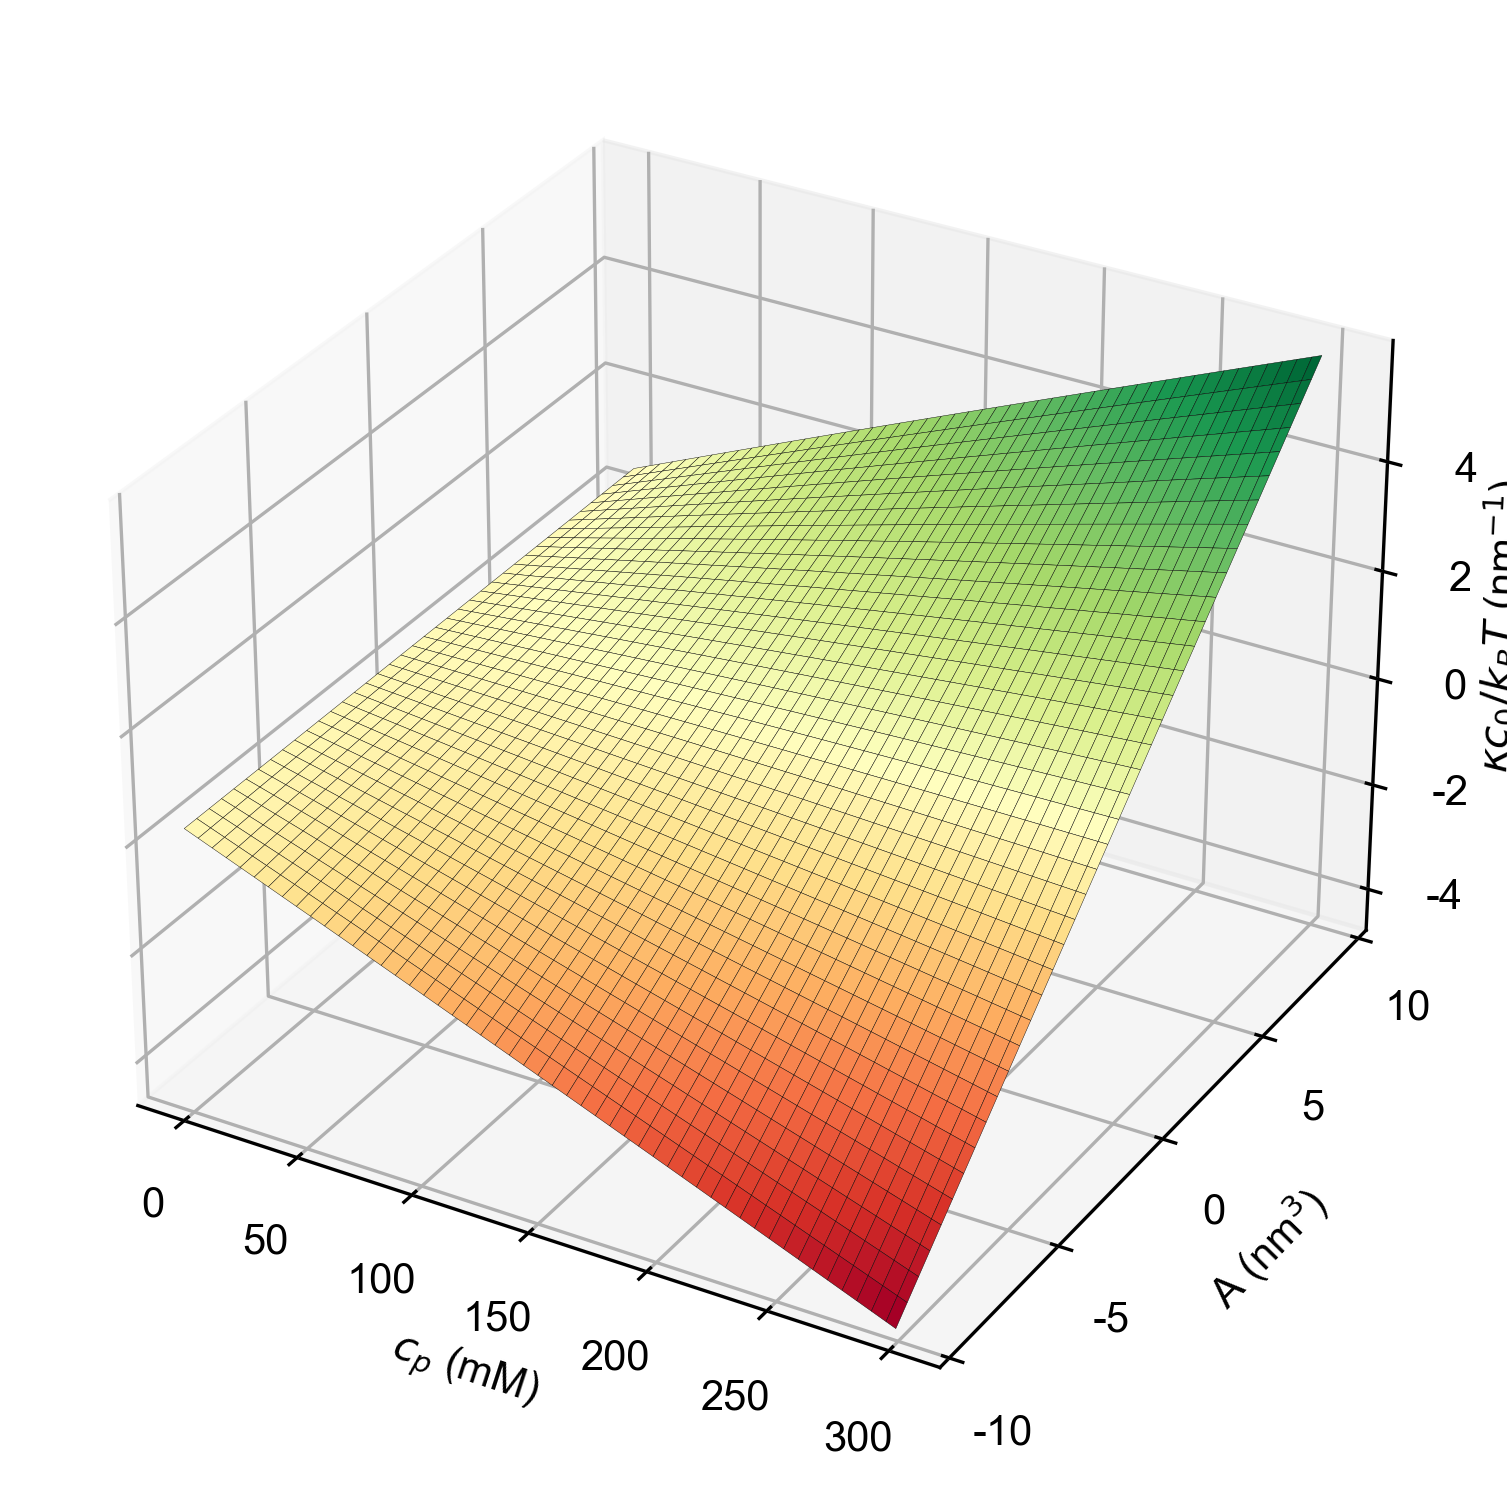

In [27]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})

# ax.set_box_aspect(aspect = (1,1,1))

cps = np.arange(1, 300, 1)
As = np.arange(-10, 10, 0.5)

# print(len(cps), len(As))
Z = np.zeros(
    (
        len(As),
        len(cps),
    )
)


for i, cp in enumerate(cps):
    for j, A in enumerate(As):
        Z[j, i] = computeForce(
            cp=cp, A=A, phi=10, i=1, a=1.0, alpha=0.1, B=0, d=200, N=600
        )

cp, A = np.meshgrid(cps, As)
surf = ax.plot_surface(cp, A, Z, cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor='k')
# surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)

ax.set_xlabel(r"$c_p$ (mM)")

ax.set_ylim((-10, 10))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")

ax.set_zlabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
ax.zaxis.set_major_formatter("{x:.0f}")
ax.zaxis.labelpad = -3

fig.tight_layout()

figName = f"phase_map"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


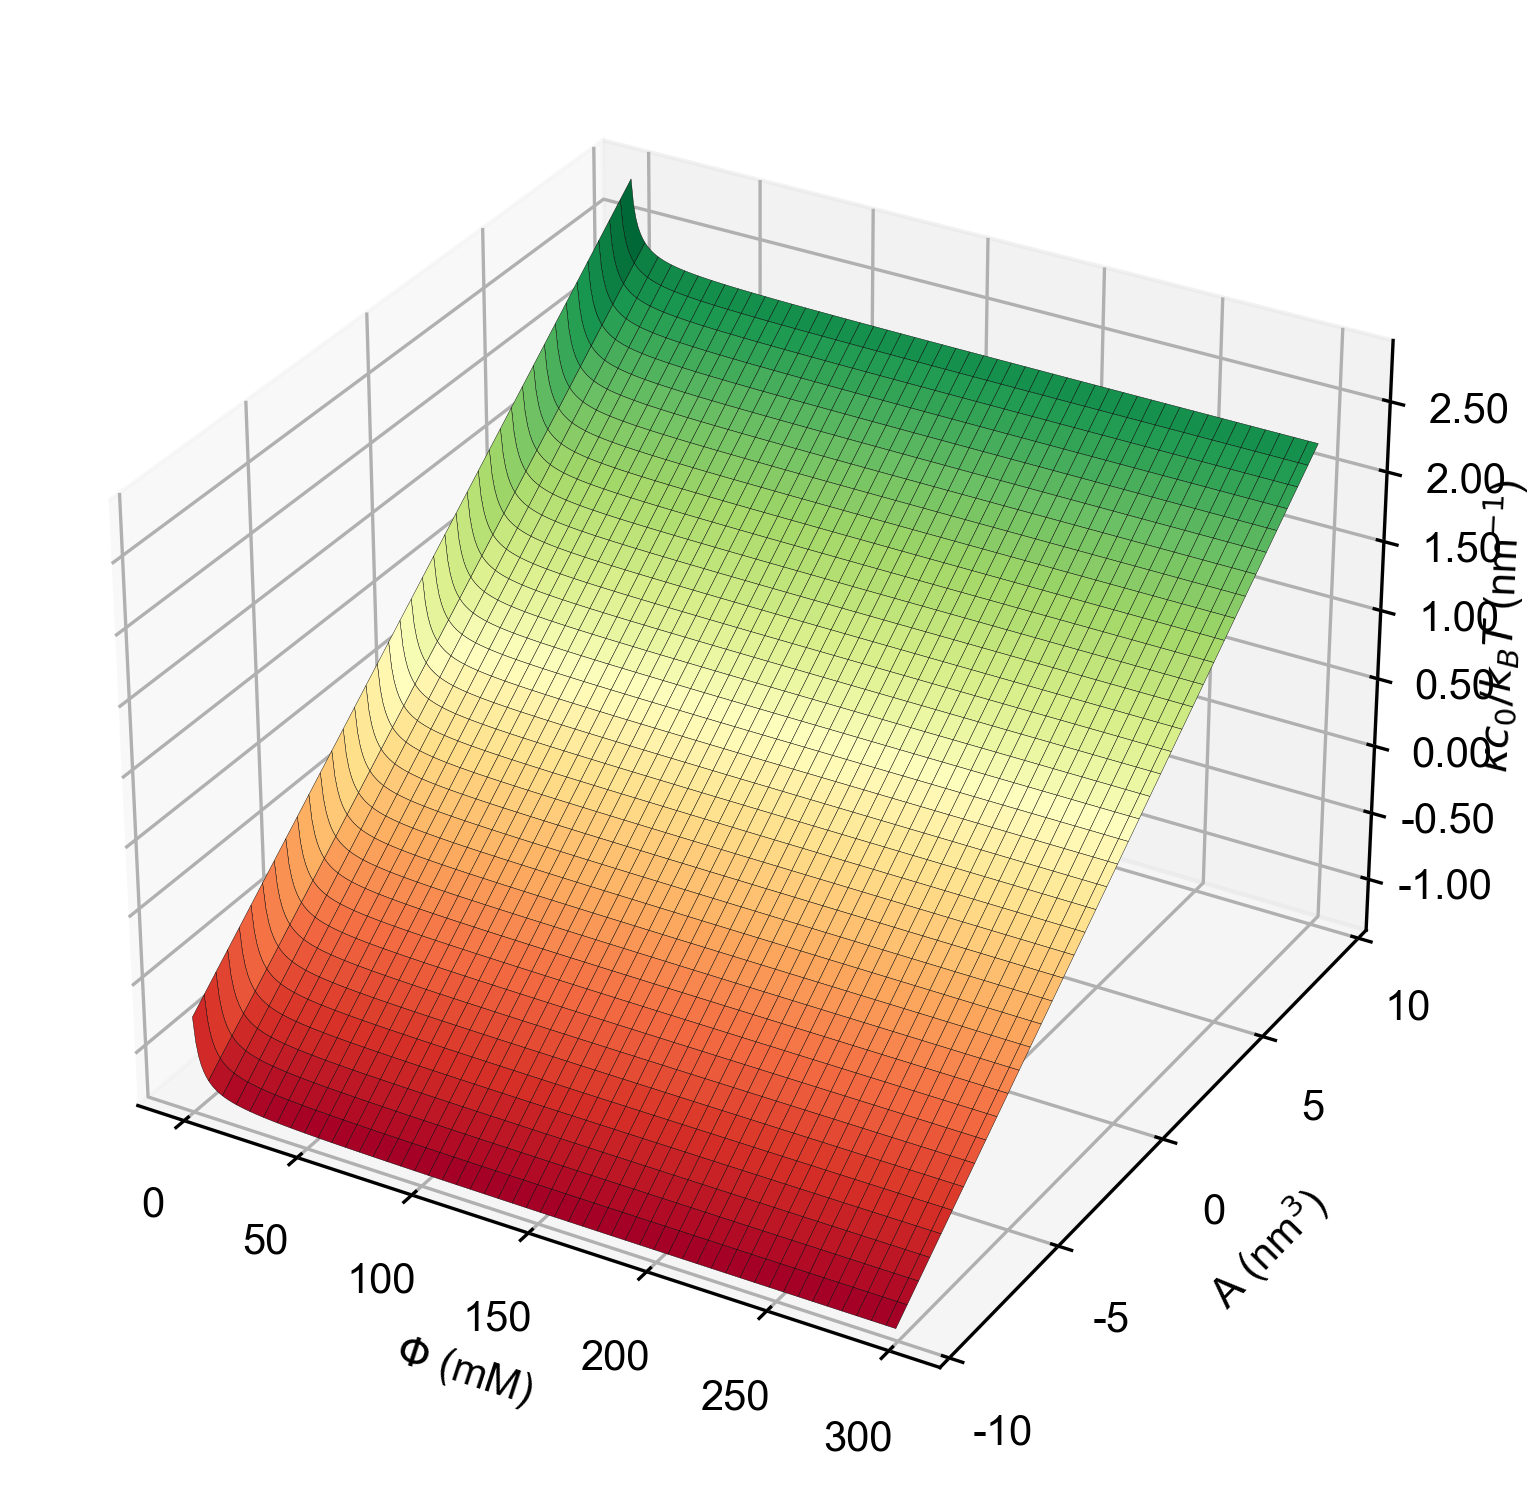

In [29]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})

# ax.set_box_aspect(aspect = (1,1,1))

cps = np.arange(1, 300, 1)
As = np.arange(-10, 10, 0.5)

# print(len(cps), len(As))
Z = np.zeros(
    (
        len(As),
        len(cps),
    )
)


for i, cp in enumerate(cps):
    for j, A in enumerate(As):
        Z[j, i] = computeForce(
            cp=100, A=A, phi=cp, i=1, a=1.0, alpha=0.1, B=0, d=200, N=600
        )

cp, A = np.meshgrid(cps, As)
surf = ax.plot_surface(cp, A, Z, cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor='k')
# surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)

ax.set_xlabel(r"$\Phi$ (mM)")

ax.set_ylim((-10, 10))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")

ax.set_zlabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
ax.zaxis.set_major_formatter("{x:.2f}")
ax.zaxis.labelpad = -3

fig.tight_layout()

figName = f"phase_map_phi"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


In [5]:
print(computeForce(cp=1, phi=1, i=1, a=1.0, alpha=0.1, A=100, B=0, N=300, d=100, verbose=True))

N = 300, len = 300.0 nm, d = 100 nm, s0 = 4981.733643307871 nm^2
elastic 0.5, virial 0.18066,  ion 0.014987537333495433
0.6956475373334954 nm^-1
0.6956475373334954


In [6]:
show_figs = False 
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

cps = np.arange(0, 500, 5)
kcc0 = np.zeros(len(cps))

for i, cp in enumerate(cps):
    kcc0[i] = computeForce(cp=cp, phi=0, i=1, a=1.0, alpha=0.1, A=100, B=0, N=300, d=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(cps, kcc0)

ax.set_xlabel(r"cp (mM)")
ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"varied_cp"

fig.savefig(curr_fig_path/f"{figName}.png", format="png")
fig.savefig(curr_fig_path/f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)

In [7]:
show_figs = False
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(50, 500, 5)
kcc0 = np.zeros(len(phis))

for i, phi in enumerate(phis):
    kcc0[i] = computeForce(cp=150, phi=phi, i=1, a=1.0, alpha=0.1, A=100, B=0, N=300, d=100) 


fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(phis, kcc0)

ax.set_xlabel(r"phi (mM)")
ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"varied_phis"

fig.savefig(curr_fig_path/f"{figName}.png", format="png")
fig.savefig(curr_fig_path/f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)

In [8]:
show_figs = False
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(5, 500, 5)
fion = np.zeros(len(phis))

alpha = 0.1
cp = milliMolarToNumberDensity(100)

N = 300
d = 200

s0 = N / (d * cp)

for i, phi in enumerate(phis):
    acop = alpha*cp/phi
    sopacop2 = np.sqrt(1+acop*acop)
    fion[i] = (-(sopacop2-1)*phi - alpha*cp*np.log(sopacop2 - acop))*s0

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(phis, fion)

ax.set_xlabel(r"phi (mM)")
ax.set_ylabel(r"$F_{ion}/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"fion"

fig.savefig(curr_fig_path/f"{figName}.png", format="png")
fig.savefig(curr_fig_path/f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)

In [9]:
show_figs = False
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(5, 500, 5)
fion = np.zeros(len(phis))

alpha = 0.1

N = 300
a = 1.0

cps = np.arange(10, 200, 10)
ds = np.arange(25, 325, 25)

data = np.zeros((len(cps), len(ds)))

for i, cpi in enumerate(cps):
    cp = milliMolarToNumberDensity(cpi)
    for j, d in enumerate(ds):
        s0 = N / (d * cp)
        data[i, j] = 1.5 / (cp * s0 * a * a)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = ax.imshow(data)

cbar = ax.figure.colorbar(
    im,
    ax=ax,
)

cbar.set_label(r"$F_{elastic}/k_BT$ (nm$^{-1}$)")

ax.set_yticks(np.arange(len(cps)), cps)
ax.set_xticks(np.arange(len(ds)), ds)

ax.set_xlabel(r"d (nm)")
ax.set_ylabel(r"cp (mM)")
fig.tight_layout()

figName = f"elastic"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


In [10]:
show_figs = False 
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(5, 500, 5)
fion = np.zeros(len(phis))

alpha = 0.1

N = 300
a = 1.0

A = 10
B = 0

cps = np.arange(10, 200, 10)
ds = np.arange(25, 325, 25)

data = np.zeros((len(cps), len(ds)))

for i, cpi in enumerate(cps):
    cp = milliMolarToNumberDensity(cpi)
    for j, d in enumerate(ds):
        s0 = N / (d * cp)
        data[i, j] = (A * cp * cp + B * cp * cp * cp) * s0

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = ax.imshow(data)

cbar = ax.figure.colorbar(
    im,
    ax=ax,
)

cbar.set_label(r"$F_{virial}/k_BT$ (nm$^{-1}$)")

ax.set_yticks(np.arange(len(cps)), cps)
ax.set_xticks(np.arange(len(ds)), ds)

ax.set_xlabel(r"d (nm)")
ax.set_ylabel(r"cp (mM)")
fig.tight_layout()

figName = f"virial"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


In [11]:
show_figs = False
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

alpha = 0.1

N = 300
a = 1.0


cps = np.arange(10, 200, 10)
ds = np.arange(25, 325, 25)

data = np.zeros((len(cps), len(ds)))

for i, cpi in enumerate(cps):
    cp = milliMolarToNumberDensity(cpi)
    for j, d in enumerate(ds):
        data[i, j] = N / (d * cp)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = ax.imshow(data)

cbar = ax.figure.colorbar(
    im,
    ax=ax,
)

cbar.set_label(r"s0 (nm$^{2}$)")

ax.set_yticks(np.arange(len(cps)), cps)
ax.set_xticks(np.arange(len(ds)), ds)

ax.set_xlabel(r"d (nm)")
ax.set_ylabel(r"cp (mM)")
fig.tight_layout()

figName = f"area"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)
